# Prophet to Predict Stock Markets

## Importing Libraries

Importing all the libraries necessaries for the algorithm to run.

In [7]:
import os
import sys

import pandas as pd

from fbprophet import Prophet, diagnostics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
from datetime import date

## Working with Data

Defining the functions to work with data.

The function get_full_dataframe is responsible to the the csv file where the data is located and dropping all the unwanted features, just leaving the open price, so we reduce the problem to an univariate time series.

The function get_train_test_dataframe is responsible to get the first 75% of the data as the train dataset.

In [8]:
index_by_reference_price = {
    'open': 1,
    'high': 2,
    'low': 3,
    'close': 4,
    'adj_close': 5 
}

def get_full_dataframe(fname, reference_price='open'):
    fpath = os.path.join('dataset/originals', fname)

    y_index = index_by_reference_price[reference_price]
    f = open(fpath, 'r')
    f.readline()
    
    d = {'ds':[], 'y': []}

    for line in f:
        split = line.split(',')
        if(split[y_index] == 'null'):
            continue
        d['ds'].append(split[0])
        d['y'].append(split[y_index])
    f.close()

    return pd.DataFrame(d)

def get_train_test_dataframe(fname, reference_price='open'):
    df = get_full_dataframe(fname, reference_price)
    rows = df.shape[0]

    train_cut = int(rows * 0.75)

    return df[:train_cut], df[train_cut:]

## Working with Prophet

Defining the functions to work with Prophet tool.

The function get_dataset_duration returns the distance (in days) between the first and last dates in the provided dataset. It receives the dataset in a pandas dataframe format as a parameter and returns the distance between the first and last date, in days.

In [9]:
DPI = 150
RESOLUTION = (3840, 2160)


def get_dataset_duration(df):
    first = [int(d) for d in df.iloc[0]['ds'].split('-')]
    last = [int(d) for d in df.iloc[-1]['ds'].split('-')]

    d0 = date(first[0], first[1], first[2])
    d1 = date(last[0], last[1], last[2])
    delta = d1 - d0
    return delta.days

The function fit_model_with_prophet simply fits a model using the entire training dataset and performs predictions on the entire dataset using the calculated parameters. Afterwards, it plots a graph of these values with predictions for a determined range in the future, so the model can be analyzed. If future_period is greater than 0, the graph will also display predictions for the number of days defined in this parameter. On the graph, the black points represent the actual values in the dataset(y), the blue line represents the predictions (yhat) and the blue shade surrounding the line represents the range of maximum and minimum value predicted by the model.

In [10]:
def fit_model_with_prophet(df, fname, future_period=730):
    output_path = 'output/prophet'

    print(df.head())
    print(df.tail())

    m = Prophet()
    m.fit(df)

    # creates a dataframe to be used for prediction (including the rows in the future period)
    future = m.make_future_dataframe(periods=future_period)
    print(future.tail())

    forecast = m.predict(future)
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

    # model graph
    fig1 = m.plot(forecast)
    fig1.suptitle('{} prediction model'.format(fname))
    fig1.figsize = (RESOLUTION[0]/DPI, RESOLUTION[1]/DPI)
    figure1_path = os.path.join(output_path, fname.replace('.csv', '_model.png'))
    fig1.savefig(figure1_path, dpi=DPI)

    # model components graphs
    figure2_path = os.path.join(output_path, fname.replace('.csv', '_model_components.png'))
    fig2 = m.plot_components(forecast)
    fig2.suptitle('{} prediction model components'.format(fname))
    fig2.figsize = (RESOLUTION[0] / DPI, RESOLUTION[1] / DPI)
    fig2.savefig(figure2_path, dpi=DPI)

The function prophet_cross_validation performs cross validation with the provided dataset and outputs all metrics and a graph, so the performance can be analyzed. It outputs all these files in a folder for a specific set of parameters. For example, running this function with the default parameters will create a folder called "cv_0.6_0.05_0.1", which means {cross_validation}_{initial_ratio}_{period_ratio}_{horizon_ratio}.

**How does Prophet perform cross validation?**

Prophet performs cross validation using cutoff dates. For example, if your dataset has a range of 10000 days, and initial_ratio = 0.6, period_ratio = 0.05 and horizon_ratio = 0.1, cross validation we'll be executed in the following way (everything represented in days). First cutoff date: last_date - (horizon) = 10000 - (10000*0.1) = 9000. So the first cutoff date will be the 9000th day. Prophet will fit the model using all the data prior to this day and will make predictions and calculate errors for all days between 9000 and 10000 (cutoff date + horizon). After this, it will "skip" backwards a period, in this case, 500 days. Second cutoff date: 9000-500 = 8500. It will fit the model again, using only data prior to the cutoff date. It will then calculate the prediction and errors for the days in a horizon range (in this iteration, from day 8500 to day 9500). It will repeat this process until the cutoff date reaches the initial range, which in this case is day 6000. It's important to set a significant initial ratio, so the model has enough data to find seasonal patterns and make predictions.

In [11]:
def prophet_cross_validation(df, fname, initial_ratio=0.6, period_ratio=0.05, horizon_ratio=0.1, rolling_window=0.1, error_metric='rmse'):
    output_path = 'output/prophet'

    print(fname.replace('.csv', '_{}_{}_{}.csv'.format(initial_ratio, period_ratio, horizon_ratio)))
    print("Performing cross validation on file: ", fname)

    duration = get_dataset_duration(df)

    initial = "{} days".format(int(initial_ratio * duration))
    period = "{} days".format(int(period_ratio * duration))
    horizon = "{} days".format(int(horizon_ratio * duration))

    print("df.shape[0] = {}, duration = {}, initial = {}, period = {}, horizon = {}".format(df.shape[0], duration, initial, period, horizon))

    print("Fitting the model...")
    m = Prophet()
    m.fit(df)

    df_cv = diagnostics.cross_validation(m, initial=initial, period=period, horizon=horizon)

    # performance metrics
    df_p = diagnostics.performance_metrics(df_cv, rolling_window=rolling_window)
    print(df_p)

    fig1 = plot_cross_validation_metric(df_cv, metric=error_metric, rolling_window=rolling_window)
    fig1.suptitle('{} cross_validation {}'.format(fname, error_metric))
    fig1.figsize = (RESOLUTION[0]/DPI, RESOLUTION[1]/DPI)

    # saving files
    suffix = '_{}_{}_{}'.format(initial_ratio, period_ratio, horizon_ratio)
    output_folder = os.path.join(output_path, 'cv' + suffix)

    if(not os.path.exists(output_folder)):
        print('creating output folder: ', output_folder)
        os.mkdir(output_folder)

    df_cv.to_csv(os.path.join(output_folder, fname.replace('.csv', suffix + '_cross_validation.csv')))

    df_p.to_csv(os.path.join(output_folder, fname.replace('.csv', suffix + '_performance_metrics.csv')))

    figure_output = os.path.join(output_folder, fname.replace('.csv', suffix + '_{}.png'.format(error_metric)))
    fig1.savefig(figure_output, dpi=DPI)

### Fit the Model and Cross Validating it

Referencing the csv file for the historical prices of a specific company and then treating the data with the get_full_dataframe function. Fitting the model with prophet with the fit_model_with_prophet function and then performing cross validation for two different error metrics, rmse and mape, with the prophet_cross_validation function.

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing file:  AAL.csv
           ds          y
0  2005-09-27  21.049999
1  2005-09-28  19.299999
2  2005-09-29  20.400000
3  2005-09-30  20.260000
4  2005-10-03  20.900000
              ds          y
3202  2018-06-18  42.630001
3203  2018-06-19  42.029999
3204  2018-06-20  41.650002
3205  2018-06-21  42.029999
3206  2018-06-22  41.459999


/Users/rafaelfariac/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


             ds
3932 2020-06-17
3933 2020-06-18
3934 2020-06-19
3935 2020-06-20
3936 2020-06-21
             ds       yhat  yhat_lower  yhat_upper
3932 2020-06-17  59.043575   29.053191   87.475053
3933 2020-06-18  59.047992   29.101752   87.063479
3934 2020-06-19  59.055010   28.367627   88.516844
3935 2020-06-20  56.676712   27.487791   85.929036
3936 2020-06-21  56.708189   26.153192   85.093739


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AAL_0.6_0.05_0.1.csv
Performing cross validation on file:  AAL.csv
df.shape[0] = 3207, duration = 4651, initial = 2790 days, period = 232 days, horizon = 465 days
Fitting the model...


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2013-05-22 00:00:00 and 2017-03-14 00:00:00


      horizon         mse       rmse        mae      mape  coverage
351   47 days   51.073823   7.146595   5.639543  0.149725  0.459821
31    48 days   51.075484   7.146711   5.640426  0.149783  0.459821
1956  48 days   51.118217   7.149701   5.646599  0.149872  0.459821
672   48 days   51.682041   7.189022   5.692632  0.151410  0.455357
993   48 days   52.414976   7.239819   5.730993  0.152069  0.455357
352   48 days   53.021961   7.281618   5.760643  0.153019  0.455357
353   49 days   53.584907   7.320171   5.787943  0.153919  0.455357
673   49 days   53.847195   7.338065   5.812312  0.154707  0.450893
32    49 days   53.763158   7.332336   5.796250  0.154513  0.455357
1634  49 days   53.754534   7.331748   5.791979  0.154210  0.455357
1957  49 days   53.786529   7.333930   5.797699  0.154311  0.455357
33    50 days   53.746287   7.331186   5.787480  0.154244  0.455357
1958  50 days   53.831703   7.337009   5.798838  0.154451  0.450893
354   50 days   54.254216   7.365746   5.819079 

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AAL_0.6_0.05_0.1.csv
Performing cross validation on file:  AAL.csv
df.shape[0] = 3207, duration = 4651, initial = 2790 days, period = 232 days, horizon = 465 days
Fitting the model...


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2013-05-22 00:00:00 and 2017-03-14 00:00:00


      horizon         mse       rmse        mae      mape  coverage
351   47 days   51.073823   7.146595   5.639543  0.149725  0.450893
31    48 days   51.075484   7.146711   5.640426  0.149783  0.450893
1956  48 days   51.118217   7.149701   5.646599  0.149872  0.450893
672   48 days   51.682041   7.189022   5.692632  0.151410  0.446429
993   48 days   52.414976   7.239819   5.730993  0.152069  0.446429
352   48 days   53.021961   7.281618   5.760643  0.153019  0.446429
353   49 days   53.584907   7.320171   5.787943  0.153919  0.446429
673   49 days   53.847195   7.338065   5.812312  0.154707  0.441964
32    49 days   53.763158   7.332336   5.796250  0.154513  0.446429
1634  49 days   53.754534   7.331748   5.791979  0.154210  0.446429
1957  49 days   53.786529   7.333930   5.797699  0.154311  0.446429
33    50 days   53.746287   7.331186   5.787480  0.154244  0.446429
1958  50 days   53.831703   7.337009   5.798838  0.154451  0.441964
354   50 days   54.254216   7.365746   5.819079 

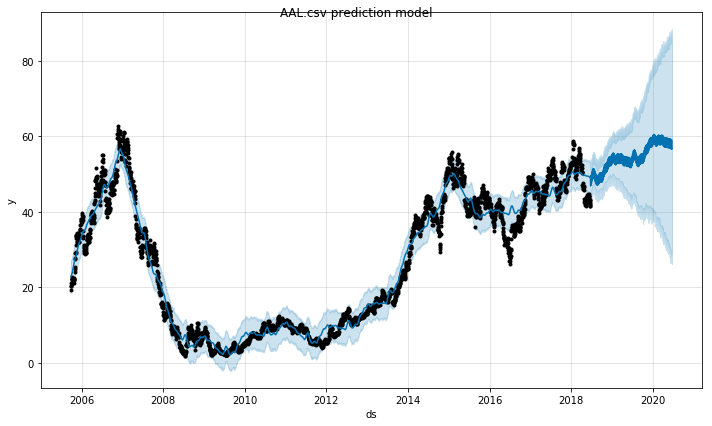

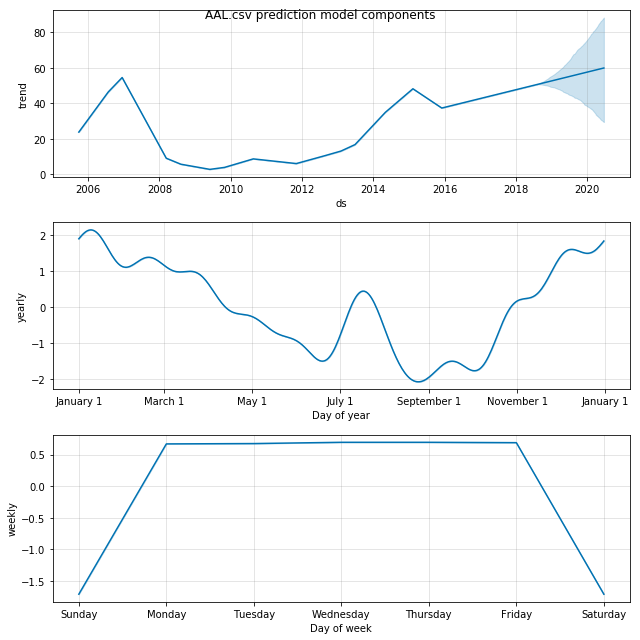

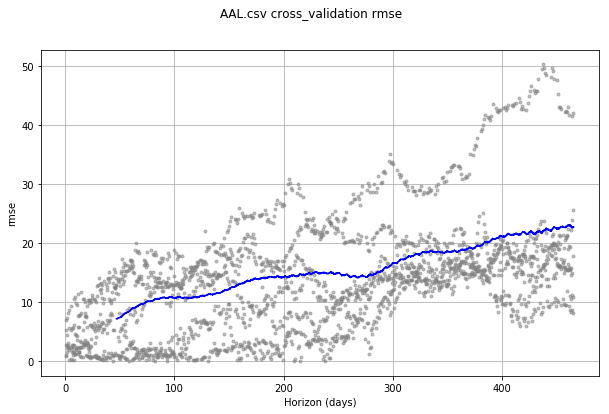

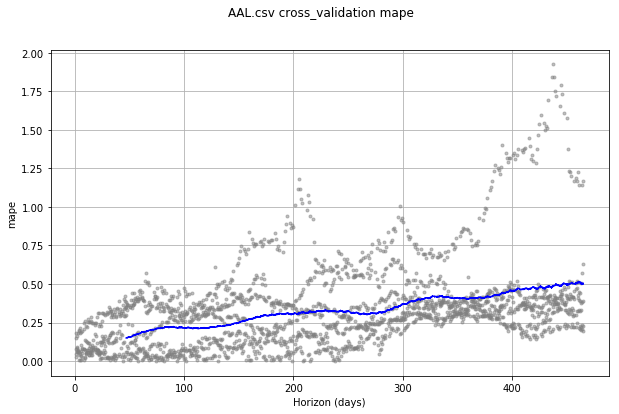

In [12]:
fname = 'AAL.csv'

print("Processing file: ", fname)
full_df = get_full_dataframe(fname)
# train_df, test_df = dataset_preparation.get_train_test_dataframe(fname)

fit_model_with_prophet(full_df, fname)
prophet_cross_validation(full_df, fname, error_metric='rmse')
prophet_cross_validation(full_df, fname, error_metric='mape')

## Getting the Results

The results for the fit and cross validation processes can be found inside the directory output>prophet.